# Mnist with Pretrained AlexNet (on ImageNet)


from Didan, Deng (ECE)

In [6]:
import os
import numpy as np
import tensorflow as tf
import cv2
from alexnet import AlexNet
from caffe_classes import class_names
from keras.utils import np_utils
from keras.datasets import mnist
# This project is revised from https://github.com/kratzert/finetune_alexnet_with_tensorflow
# before you implement this code, make sure you have download the pretrained weights, 
# which you can find [here](http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/) 
# and put the weights in the current working directory

## 1. Data importing and model Initialization

Mnist dataset is the famous image dataset with handwritten digits gray pictures in the size of (28, 28). Here I use Keras to import mnist data into standard input format : (x_train_image, y_train_label) and (x_test_image, y_test_label). In the train set, there are 60000 samples and in the test set, there are 10000 samples in total.

In [2]:
# load mnist data from keras
(x_train_image, y_train_label), (x_test_image, y_test_label) = mnist.load_data()

# print the number of images in training and testing set
print("train data records=", len(x_train_image))

print("test data records=", len(x_test_image))

# print the shape of input images and labels:
print("x_train image format=", x_train_image.shape)

print("y_train label format=", y_train_label.shape)


train data records= 60000
test data records= 10000
x_train image format= (60000, 28, 28)
y_train label format= (60000,)


The model `AlexNet()` here is defined in `./alexnet.py`, in which the network architecture is based on this [paper](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). The default configuration of this model is pretrain-weights loaded.

As for the pretrained weights `bvlc_alexnet.npy`, it can be converted from the caffe library using [caffe-to-tensorflow](https://github.com/ethereon/caffe-tensorflow). The original file is converted by [guerzh]https://github.com/guerzh/tf_weights . 

Using `model = AlexNet(x, keep_prob, 1000, [])` is because the AlexNet was pretrained on ImageNet with 1000 classes, here I use 1000 as the number of classess for initialization. Since our work is to extract the ouput of fc7 as features, it really has nothing to do with the number of neurons in the last layer.

In [3]:
current_dir = os.getcwd()
feature_dir = os.path.join(current_dir, 'feature')
# reset the default graph
tf.reset_default_graph() 

#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config 
model = AlexNet(x, keep_prob, 1000, [])

# get the fc7 ouput as feature
feature_output = model.fc7
        

## 2. Feature Extraction
For the first time you run the cell, it will generate two 'xx_features.txt' in '\feature' folder. Next time you run it again, those features can be directly read.


In [4]:
from tqdm import tqdm
import pickle
train_dest = os.path.join(feature_dir,"train_features.txt") # the path where train_features have been stored
test_dest = os.path.join(feature_dir, "test_features.txt")
train_features = []
test_features = []
# whether the feature files have already existed
if os.path.exists(train_dest) and os.path.exists(test_dest):
    with open(train_dest, "rb") as ftr:
        train_features = pickle.load(ftr)
        print("train_features loaded.")
    with open(test_dest, "rb") as fte:
        test_features =  pickle.load(fte)
        print("test_features loaded.")
else:
    # extracting features ...
    with tf.Session() as sess:

        # Initialize all variables
        sess.run(tf.global_variables_initializer())

        # Load the pretrained weights into the model
        model.load_initial_weights(sess)

        # Loop through all images in train set
        for i, image in tqdm(enumerate(x_train_image)):

            # Convert image to float32 and resize to (227x227)
            img = cv2.resize(image.astype(np.float32), (227,227))
            img = img.reshape((227, 227, 1)) 

            # Reshape and zero padding in the other two dimensions as needed to feed into model 
            pad_zeros = np.zeros((227, 227, 2))
            img = np.concatenate ((img, pad_zeros), axis = 2)        
            img = img.reshape((1,227,227,3))

            # Run the session and calculate the feature and append them together
            train_feature = sess.run(feature_output, feed_dict={x: img, keep_prob: 1})
            train_features.append(train_feature)
            pass
        print ("Feature extraction for train set is done.")

        # Loop through all images in test set
        for i, image in tqdm(enumerate(x_test_image)):

            # Convert image to float32 and resize to (227x227)
            img = cv2.resize(image.astype(np.float32), (227,227))
            img = img.reshape((227, 227, 1)) 

            # Reshape and zero padding in the other two dimensions as needed to feed into model 
            pad_zeros = np.zeros((227, 227, 2))
            img = np.concatenate ((img, pad_zeros), axis = 2)        
            img = img.reshape((1,227,227,3))

            # Run the session and calculate the feature and append them together
            test_feature = sess.run(feature_output, feed_dict={x: img, keep_prob: 1})
            test_features.append(test_feature)
            pass
        print ("Feature extraction for test set is done.")
    # save it 
    with open(train_dest,"wb") as fp:
        pickle.dump(train_features, fp)
    with open(test_dest,"wb") as fp:
        pickle.dump(test_features, fp)
        

train_features loaded.
test_features loaded.


## 3. Feature Visualization

### 3.1 Using PCA
PCA is a technique for reducing the number of dimensions in a dataset whilst retaining most information. It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed. 

Since I want to demonstrate the pca_result in 2-D plots, it's reasonable to set the number of major components in pca to be 3, and see how much variance can be explained the first 2 or 3 components. 

In [5]:
# PCA Visualization using Scikit-Learn implementation of PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
train_features_array = np.asarray(train_features).reshape(60000, 4096)
pca_result = pca.fit_transform(train_features_array)
# the first three components 
pca_one = pca_result[:,0]
pca_two = pca_result[:,1]
pca_three = pca_result[:,2]
print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.21207708 0.11231221 0.06852579]


It turns out that the first 3 components can keep less than 40% of variance, and the the first two components can explain 32% of it. I plot the first two components in pca_result to see if these two features are enough for classfiying those digits apart.

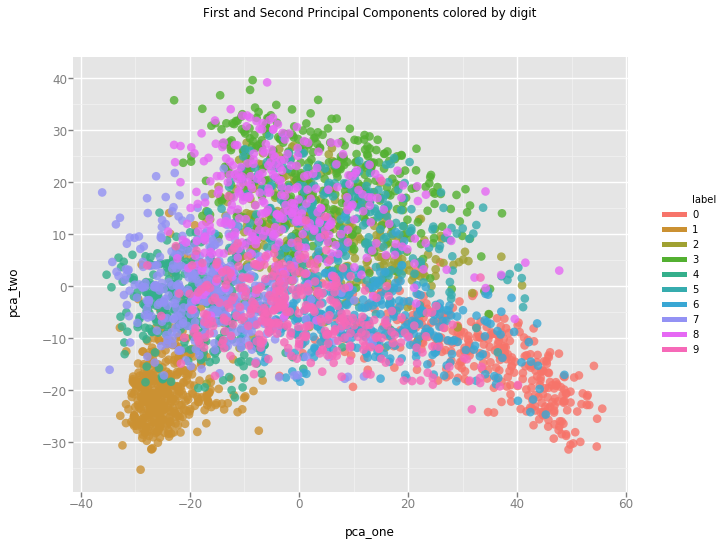

<ggplot: (8792676960653)>

In [7]:
import pandas as pd
from ggplot import *
# create the dataframe of pca_data : 'pca_one':the first component;'pca_two':the second component; 'label': labels
pca_data = {'pca_one': pca_one, 'pca_two': pca_two, 'label': y_train_label}
df = pd.DataFrame(data = pca_data)
df['label'] = df['label'].apply(lambda i: str(i))
rndperm = np.random.permutation(df.shape[0])

ggplot( df.loc[rndperm[:3500],:], aes(x='pca_one', y='pca_two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")


From this scatterplot, it's clear that the first two components in pca_result cannot do classification very well. The dots from different digits types are mixed together. It's hard to seperate them by bare eyes.

However, PCA is very effective in reducing the dimensionality of data without losing too much information, which can be implemented later.

### 3.2 Using t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction, by minimizing the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

The main drawback of t-SNE is that it scales quadratically in the number of objects N, which makes it run very slowly on large-scale dataset. To save memory and power/time, I will only use the first 5,000 samples to run the algorithm on. The total execution time as shown below, is around 3 min.

In [8]:
# visualization using t-SNE
# Since t-SNE scales quadratically in the number of objects N
# To save memory and power/time I will only use the first 5,000 samples to run the algorithm on.
import time

from sklearn.manifold import TSNE

n_sne = 5000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_features_array[:n_sne])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 1.237s...
[t-SNE] Computed neighbors for 5000 samples in 163.558s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 10.151048
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.264183
[t-SNE] Error after 300 iterations: 2.014596
t-SNE done! Time elapsed: 193.19891667366028 seconds


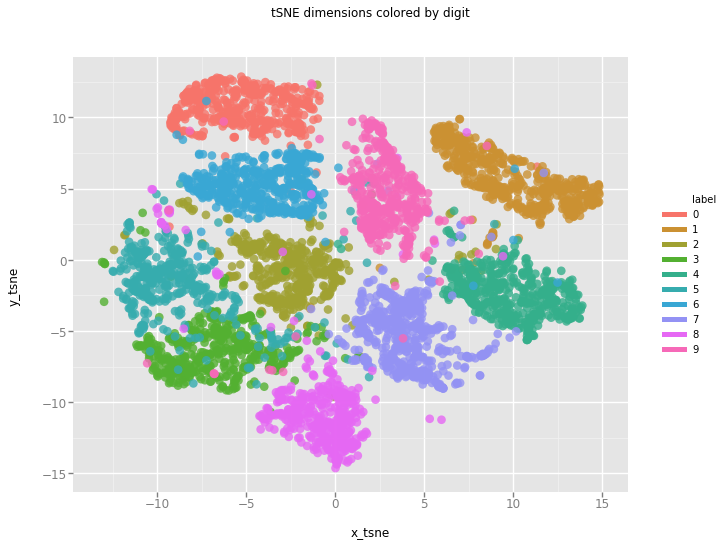

<ggplot: (8792664000653)>

In [20]:
x_tsne = tsne_results[:,0]
y_tsne = tsne_results[:,1]

tsne_data = {"x_tsne": x_tsne, "y_tsne": y_tsne, "label": y_train_label[:n_sne]}
df_tsne = pd.DataFrame(data = tsne_data)
df_tsne['label'] = df_tsne['label'].apply(lambda i: str(i))

ggplot( df_tsne.loc[:n_sne,:], aes(x='x_tsne', y='y_tsne', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("tSNE dimensions colored by digit")


Compared with the plot in previous cells, where I used PCA for dimensionality reducing, this is a significant improvement. Because almost all digits are very clearly clustered in their own groups.

Next, to further reduce execution time, I explore the method combining pca and t-sne together: 
First, using PCA to reduce the dimensionality of features to 50.
Then,  feeding the pca components into the t-SNE algorithm.

In [27]:
# Appendex : t-SNE on PCA-reduced data
# reduce the number of dimensions before feeding the data into the t-SNE algorithm
# first, using PCA to reduce the dimensionality of features to 50
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(train_features_array)

print ('Explained variation per principal component (PCA): {}'.format(np.sum(pca_50.explained_variance_ratio_)))

#T-sne using 50 dimensionality ,only use 5000 samples
n_sne_50 = 10000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50[:n_sne_50])


print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Explained variation per principal component (PCA): 0.8529222011566162
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 5.902s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 7.885215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.156052
[t-SNE] 

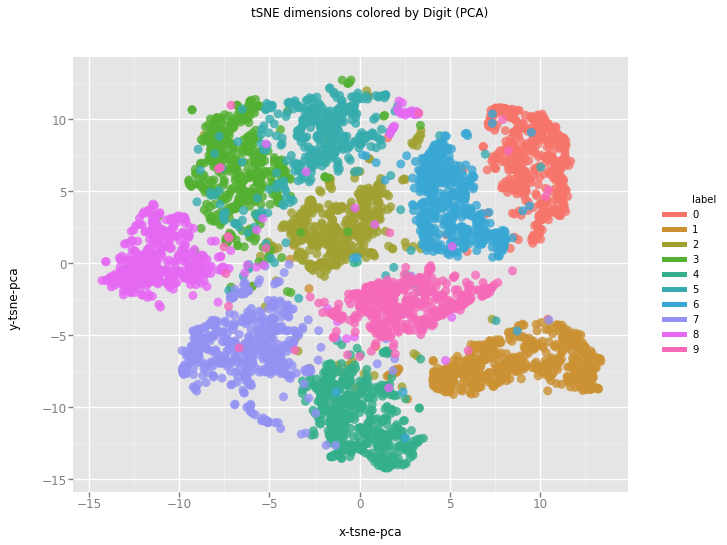

<ggplot: (-9223363244190771964)>

In [26]:
# visualization

df_tsne_50 = df_tsne.loc[:n_sne_50, :].copy()
df_tsne_50['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne_50['y-tsne-pca'] = tsne_pca_results[:,1]

ggplot( df_tsne_50, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=80,alpha=0.8) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")

You can see there is a great reduction of execution time (from 3 min to 1min), and from visualization, the clustering performance is fair.

## 4. SVM Classification

SVM,( also support vector machines ) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Generally, it constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space. And to achieve a good separation, the hyperplane needs to the largest distance to the nearest training-data point of any class (so-called functional margin).

Here I implement sklearn.svm.SVC for SVM model. Usually, three hyperparameters are really important for SVM: the kernel type, 'C' and 'gamma'. Typcial method is to use gridsearch and cross validation for parameter optimization. But to save time, I will skip gridsearch and cross validation, simply assign `C = 10, gamma = 0.001, kernel = 'rbf'` to .SVC(). Therefore, the accuracy on test set may not be the greatest.

In [5]:
# SVM classification with original features
import time
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
train_features_array = np.asarray(train_features).reshape(60000, 4096)

time_start = time.time()
clf = SVC(C = 10, gamma = 0.001, kernel = 'rbf')
clf.fit(train_features_array, y_train_label)

print ('training done! Time elapsed: {} seconds'.format(time.time()-time_start))

test_features_array = np.asarray(test_features).reshape(10000, 4096)
time_start = time.time()
y_preds = clf.predict(test_features_array)

print ('prediction done ! Time elapsed: {} seconds'.format(time.time()-time_start))

score = accuracy_score(y_test_label, y_preds)
print ("The accuracy score on test set is: ", score)

training done! Time elapsed: 2500.3675742149353 seconds
prediction done ! Time elapsed: 488.3988206386566 seconds
The accuracy score on test set is:  0.9896


The training process spent over 40 min and evaluation used 8 min. The final accuracy on test set is 0.9896 , which is fairly. 
The drawback of this method is too time-consuming. Remember that PCA can serve as a good technique to reduce feature dimentionality, therefore, then I used pca to reduce the features dimension to 100, and then feed the data to SVM model for training again.

In [16]:
# Using PCA as a feature selection method, then apply SVM
from sklearn.decomposition import PCA

pca_100 = PCA(n_components=100)
total_features = np. concatenate((train_features_array,test_features_array), axis =0)
pca_result_100 = pca_100.fit_transform(total_features)

print ('Explained variation per principal component (PCA): {}'.format(np.sum(pca_100.explained_variance_ratio_)))

Explained variation per principal component (PCA): 0.9032503810487111


In [18]:
time_start = time.time()
clf = SVC(C = 10, gamma = 0.001, kernel = 'rbf')
# training must be only on training set features
clf.fit(pca_result_100[:60000,:], y_train_label)

print ('training done! Time elapsed: {} seconds'.format(time.time()-time_start))

time_start = time.time()
y_preds = clf.predict(pca_result_100[60000:,:])

print ('prediction done ! Time elapsed: {} seconds'.format(time.time()-time_start))

score = accuracy_score(y_test_label, y_preds)
print ("The accuracy score on test set is: ", score)

training done! Time elapsed: 55.03184127807617 seconds
prediction done ! Time elapsed: 11.817339420318604 seconds
The accuracy score on test set is:  0.9894


This time, the training time deceased drastically, by 97.5%. And the same for evaluation time, which has been reduced by 98%. And the performance on test set is still good, only degrading by 0.0002. I think in practice, this performance degradation is acceptable considering the huge execution time saved. 

## Reference:
[Github: finetune_alexnet_with_tensorflow](https://github.com/kratzert/finetune_alexnet_with_tensorflow)

[Blog: Visualization using PCA and t-SNE](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

[sklearn SVM SVC](scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)